In [64]:
import json, time
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

In [3]:
USERNAME = ""
APIKEY = ""

In [4]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [5]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [6]:
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

In [7]:
CITY_LOCATIONS = {
    "odessa": {"city"   : "Odessa",
               "county" : "Ector",
               "state"  : ["Texas", "TX"],
               "fips"   : "48135",
               "latlon" : [31.88, -102.35] } 
}

In [8]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [24]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['odessa']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['odessa']['fips'][2:]


def request_yearly_summary(params, year, request_data):
    request_data['param'] = params
    gaseous_aqi = request_daily_summary(request_template = request_data, begin_date = f"{year}0501", end_date = f"{year}1031")

    if gaseous_aqi["Header"][0]["status"] == "Success":
        return gaseous_aqi["Data"]
    return None

In [69]:
years = [str(y) for y in range(1964, 2025)]
gas_aqi_list = []
for y in years:
    gas_agi = request_yearly_summary(AQI_PARAMS_GASEOUS, y, request_data)
    if not gas_agi:
        continue
    gas_aqi_list += gas_agi

In [70]:
df = pd.DataFrame(gas_aqi_list)
df

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,48,135,0001,42401,1,31.873458,-102.346254,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"MHMR BUILDING, ROOF",Texas,Ector,Odessa,36220,"Odessa, TX",2013-06-11
1,48,135,0001,42401,1,31.873458,-102.346254,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"MHMR BUILDING, ROOF",Texas,Ector,Odessa,36220,"Odessa, TX",2013-06-11
2,48,135,0001,42401,1,31.873458,-102.346254,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"MHMR BUILDING, ROOF",Texas,Ector,Odessa,36220,"Odessa, TX",2013-06-11
3,48,135,0001,42401,1,31.873458,-102.346254,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"MHMR BUILDING, ROOF",Texas,Ector,Odessa,36220,"Odessa, TX",2013-06-11
4,48,135,0001,42401,1,31.873458,-102.346254,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"MHMR BUILDING, ROOF",Texas,Ector,Odessa,36220,"Odessa, TX",2013-06-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17963,48,135,0002,44201,2,31.872347,-102.352921,WGS84,Ozone,W,...,014,INSTRUMENTAL - CHEMILUMINESCENCE,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2023-02-05
17964,48,135,0002,44201,2,31.872347,-102.352921,WGS84,Ozone,1,...,014,INSTRUMENTAL - CHEMILUMINESCENCE,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2018-07-20
17965,48,135,0002,44201,2,31.872347,-102.352921,WGS84,Ozone,W,...,014,INSTRUMENTAL - CHEMILUMINESCENCE,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2023-02-05
17966,48,135,0002,44201,2,31.872347,-102.352921,WGS84,Ozone,W,...,014,INSTRUMENTAL - CHEMILUMINESCENCE,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2023-02-05


In [71]:
years = [str(y) for y in range(1964, 2025)]
particulates_aqi_list = []
for y in years:
    particulates_aqi = request_yearly_summary(AQI_PARAMS_PARTICULATES, y, request_data)
    if not particulates_aqi:
        continue
    particulates_aqi_list += particulates_aqi

In [72]:
df_part = pd.DataFrame(particulates_aqi_list)
df_part

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,48,135,0002,81102,1,31.872347,-102.352921,WGS84,PM10 Total 0-10um STP,7,...,052,HI-VOL-SA321A - GRAVIMETRIC,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2024-05-22
1,48,135,0002,81102,1,31.872347,-102.352921,WGS84,PM10 Total 0-10um STP,7,...,052,HI-VOL-SA321A - GRAVIMETRIC,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2024-05-22
2,48,135,0002,81102,1,31.872347,-102.352921,WGS84,PM10 Total 0-10um STP,7,...,052,HI-VOL-SA321A - GRAVIMETRIC,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2024-05-22
3,48,135,0002,81102,1,31.872347,-102.352921,WGS84,PM10 Total 0-10um STP,7,...,052,HI-VOL-SA321A - GRAVIMETRIC,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2024-05-22
4,48,135,0002,81102,1,31.872347,-102.352921,WGS84,PM10 Total 0-10um STP,7,...,052,HI-VOL-SA321A - GRAVIMETRIC,None,3008 E. UNIVERSITY BLVD. & PARKER PARK,Texas,Ector,Odessa,36220,"Odessa, TX",2024-05-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23429,48,135,1014,88101,1,31.870259,-102.334745,NAD83,PM2.5 - Local Conditions,X,...,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Odessa Gonzales,2700 Disney,Texas,Ector,Odessa,36220,"Odessa, TX",2024-09-23
23430,48,135,1014,88101,1,31.870259,-102.334745,NAD83,PM2.5 - Local Conditions,X,...,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Odessa Gonzales,2700 Disney,Texas,Ector,Odessa,36220,"Odessa, TX",2024-09-23
23431,48,135,1014,88101,1,31.870259,-102.334745,NAD83,PM2.5 - Local Conditions,X,...,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Odessa Gonzales,2700 Disney,Texas,Ector,Odessa,36220,"Odessa, TX",2024-09-23
23432,48,135,1014,88101,1,31.870259,-102.334745,NAD83,PM2.5 - Local Conditions,X,...,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Odessa Gonzales,2700 Disney,Texas,Ector,Odessa,36220,"Odessa, TX",2024-09-23


In [73]:
df.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [74]:
df_gas_data_aqi = df[["date_local", "aqi"]].copy()
df_gas_data_aqi['date_local'] = pd.to_datetime(df_gas_data_aqi['date_local'])
df_gas_data_aqi.dropna(subset=["aqi"], inplace=True)
yearly_gas_aqi_mean = df_gas_data_aqi.groupby(df_gas_data_aqi['date_local'].dt.year)['aqi'].mean().reset_index()
yearly_gas_aqi_mean


,date_local,aqi
0,1976,31.270527
1,1977,33.388972
2,1978,31.820884
3,1979,32.940632
4,1980,38.103785
5,1981,24.377628
6,1982,27.619654
7,1983,29.702920
8,1984,29.763705
9,1986,32.613489


In [75]:
df_part_data_aqi = df_part[["date_local", "aqi"]].copy()
df_part_data_aqi['date_local'] = pd.to_datetime(df_part_data_aqi['date_local'])
df_part_data_aqi.dropna(subset=["aqi"], inplace=True)
yearly_part_aqi_mean = df_part_data_aqi.groupby(df_part_data_aqi['date_local'].dt.year)['aqi'].mean().reset_index()
yearly_part_aqi_mean

,date_local,aqi
0,1985,28.142857
1,1986,21.939394
2,1987,21.247059
3,1988,22.615385
4,1989,30.300000
5,1990,19.680000
6,1991,18.437500
7,1995,20.600000
8,1996,21.533333
9,1999,43.166667


In [77]:
yearly_full_aqi_mean = pd.concat([yearly_gas_aqi_mean, yearly_part_aqi_mean])
yearly_full_aqi_mean.groupby("date_local")['aqi'].mean().reset_index()

,date_local,aqi
0,1976,31.270527
1,1977,33.388972
2,1978,31.820884
3,1979,32.940632
4,1980,38.103785
5,1981,24.377628
6,1982,27.619654
7,1983,29.702920
8,1984,29.763705
9,1985,28.142857


In [79]:
df_within_650_miles_away_from_odessa_from_1964 = pd.read_csv("df_within_650_miles_away_from_odessa_from_1964.csv")
df_within_650_miles_away_from_odessa_from_1964

,Unnamed: 0,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa,distance_category,smoke_density_estimate
0,1088,No Fire Name Provided (2),1964,4996.316663,Wildfire,373.351159,7.0,0.522748
1,1089,No Fire Name Provided (2),1964,4995.725599,Wildfire,362.368863,7.0,0.538527
2,1090,No Fire Name Provided (8),1964,4995.523496,Wildfire,369.008437,7.0,0.528816
3,1091,No Fire Name Provided (4),1964,4995.490068,Wildfire,365.751696,7.0,0.533521
4,1092,No Fire Name Provided (2),1964,4995.263602,Wildfire,402.522014,8.0,0.484762
...,...,...,...,...,...,...,...,...
20991,118230,Orilla Verde Recreation Area - Salt Cedar Remo...,2017,4.440648,Prescribed Fire,362.940893,7.0,0.025809
20992,118237,1_MA_Hay Hollow North Fork (1),2018,5836.041286,Prescribed Fire,121.431462,2.0,103.254706
20993,118239,2_GUSG_TFO_West Rim Rx (1),2018,980.773974,Prescribed Fire,553.617641,11.0,3.806114
20994,118355,2_HL_Jackpot Burn 20 (1),2019,160.481181,Prescribed Fire,387.710668,7.0,0.905450


In [81]:
df_smoke_estimate_by_year = df_within_650_miles_away_from_odessa_from_1964.groupby('fire_year')['smoke_density_estimate'].mean().reset_index()
df_smoke_estimate_by_year.head()

,fire_year,smoke_density_estimate
0,1964,0.048402
1,1965,0.027459
2,1966,0.037424
3,1967,0.187720
4,1968,0.623827


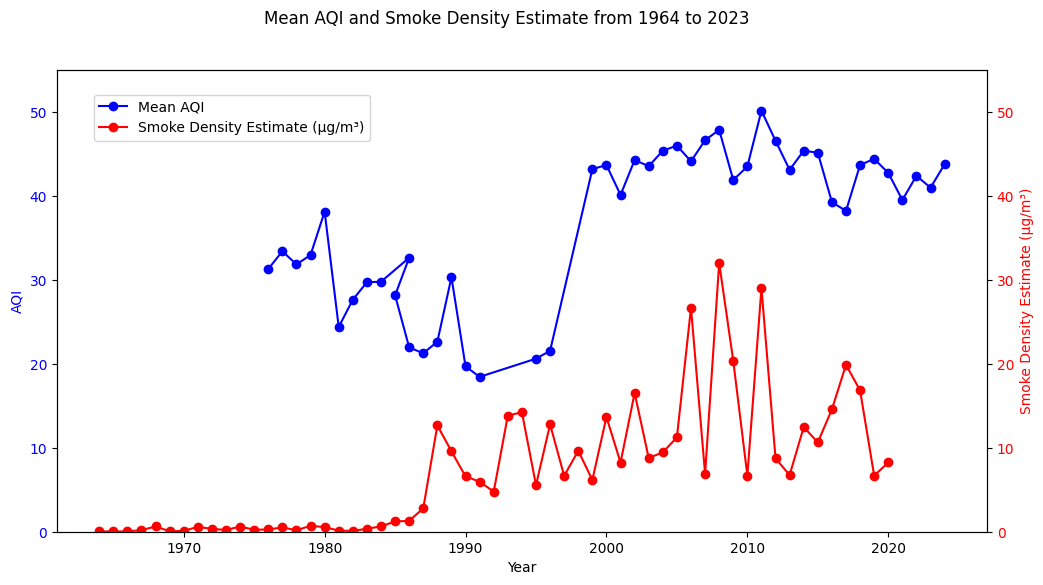

In [104]:
# missing some years
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_full_aqi_mean['date_local'], yearly_full_aqi_mean['aqi'], marker = 'o', color='b')
ax1.set_xlabel("Year")
ax1.set_ylabel("AQI", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(0, 55)

ax2 = ax1.twinx()
ax2.plot(df_smoke_estimate_by_year['fire_year'], df_smoke_estimate_by_year['smoke_density_estimate'], marker='o', color='r')
ax2.set_ylabel("Smoke Density Estimate (µg/m³)", color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 55)
fig.suptitle("Mean AQI and Smoke Density Estimate from 1964 to 2023")
fig.legend(['Mean AQI', 'Smoke Density Estimate (µg/m³)'], loc="upper left", bbox_to_anchor=(0.15, 0.85))

plt.show()
